In [ ]:
import google.generativeai as genai
import re
from typing import List, Dict
genai.configure(api_key="API_KEY")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = genai.GenerativeModel("models/gemini-1.5-flash-latest")

In [3]:
def build_prompt_A(keywords: List[str], company_context: str) -> str:
    keyword_str = ", ".join(keywords)
    return f"""
You are an AI assistant helping generate realistic, human-like questions for users interested in: {keyword_str}
Business context: "{company_context}"

Your task:
- Write natural-language questions that someone might ask an AI like ChatGPT, Siri, or Google Assistant.
- Use full question sentences (e.g., "What are the best electric vehicles for families?")
- Avoid keyword-only phrases (e.g., "cheap family suv") or SEO-style fragments.
- Questions should reflect curiosity, comparison, and buying decisions.

Each output must:
- Be a single full question, not a phrase
- Avoid using "you", "we", or direct reference to the assistant
- Avoid brand names unless required for clarity

Output format:
label: question
(Example labels: explore, compare, decide, learn)

Return only the labeled questions, no bullet points or commentary.
"""


In [4]:
def build_prompt_B(keywords: List[str], company_context: str) -> str:
    keyword_str = ", ".join(keywords)
    return f"""
Generate realistic, human-style questions someone might ask about: {keyword_str}
Context: {company_context}

The questions should:
- Be full sentences that sound like they're for an AI assistant
- Avoid keyword phrases like "cheap suv family"
- Be natural, clear, and human-like

Use format:
label: question

Return only the labeled questions, one per line.
"""


In [5]:
def generate_questions(prompt: str, labeled: bool = True, debug: bool = True) -> List[Dict[str, str]]:
    """
    Generate a list of search-style questions from Gemini based on a prompt.
    
    Args:
        prompt (str): The input prompt to Gemini.
        labeled (bool): Whether to expect intent labels like 'compare: ...'.
        debug (bool): Print raw Gemini output for inspection.
    
    Returns:
        List[Dict[str, str]]: A list of dicts with 'intent' and 'question' keys.
    """
    try:
        response = model.generate_content(prompt)
        raw_output = response.text.strip()

        if debug:
            print("\nGemini Raw Output:\n" + raw_output)

        lines = raw_output.split("\n")
        questions = []

        for line in lines:
            clean_line = line.strip()
            if not clean_line or len(clean_line) < 10:
                continue  # skip empty or short lines

            if labeled:
                # Look for "intent: question" or "intent - question"
                match = re.match(r"([a-zA-Z0-9_ -]+)\s*[:\-–]\s*(.+)", clean_line)
                if match:
                    intent, question = match.groups()
                    questions.append({
                        "intent": intent.strip().lower(),
                        "question": question.strip()
                    })
                else:
                    # Fallback: assume it's just a question with unknown label
                    questions.append({
                        "intent": "unknown",
                        "question": clean_line
                    })
            else:
                # Abstracted version (not used here, but left for future use)
                questions.append({
                    "intent": "abstracted",
                    "question": clean_line
                })

        return questions

    except Exception as e:
        print(f"Error generating questions: {e}")
        return []

In [6]:
import praw

# Setup your Reddit client
reddit = praw.Reddit(
    client_id="L_nmG8JZf59KOgT1tQBGlw",
    client_secret="yCsedpckhc85utc1iTjKj2MBGil0jA",
    user_agent="new_app_erez/0.1 by u/FindingKindly2754"
)



In [7]:
def count_relevant_reddit_posts(question: str, reddit_client, max_posts: int = 100) -> int:
    """
    Search Reddit for the question and count how many of the top post titles
    contain overlapping words with the question.

    Args:
        question (str): The generated question to evaluate.
        reddit_client (praw.Reddit): An authenticated Reddit client (PRAW).
        max_posts (int): Maximum number of posts to scan.

    Returns:
        int: Number of relevant Reddit titles (out of `max_posts`).
    """
    try:
        # Search Reddit
        results = reddit_client.subreddit("all").search(question, limit=max_posts)
        question_words = set(question.lower().split())
        matched = 0

        for post in results:
            title_words = set(post.title.lower().split())
            common = question_words & title_words
            if len(common) >= 2:
                matched += 1

        return matched

    except Exception as e:
        print(f"Reddit error for question '{question}': {e}")
        return 0

In [8]:
def evaluate_prompt_relevance(
    questions: List[Dict[str, str]],
    reddit_client,
    max_posts_per_question: int = 100
) -> float:
    """
    Evaluate how relevant a list of questions is based on Reddit search results.

    Args:
        questions (List[Dict[str, str]]): List of questions (each with 'question' key).
        reddit_client: PRAW Reddit client.
        max_posts_per_question (int): How many posts to fetch per Reddit query.

    Returns:
        float: Average number of relevant Reddit hits per question.
    """
    total_score = 0
    question_count = 0

    for q in questions:
        question_text = q["question"]
        matches = count_relevant_reddit_posts(question_text, reddit_client, max_posts=max_posts_per_question)
        print(f"{question_text} → {matches}/100 relevant")
        total_score += matches
        question_count += 1

    if question_count == 0:
        return 0.0

    avg_score = total_score / question_count
    print(f"\nAverage relevance score: {avg_score:.2f} per question")
    return avg_score


In [9]:
def improve_prompt_with_gemini(prompt_a: str, prompt_b: str, score_a: float, score_b: float) -> str:
    """
    Ask Gemini to generate a new, improved prompt based on scores of A and B.

    Returns:
        str: The improved prompt text.
    """
    prompt = f"""
We are testing two prompts to generate search-style questions with keywords.

Prompt A (score: {score_a}):
\"\"\"{prompt_a.strip()}\"\"\"

Prompt B (score: {score_b}):
\"\"\"{prompt_b.strip()}\"\"\"

Please generate a new improved prompt that combines the strengths of both.
Avoid weaknesses. Make the instructions simple, clear, and effective.

The new prompt should create human like question that people might ask and agenet,
all newly generated questions should be question style.
Output only the new prompt (no explanation).
"""
    response = model.generate_content(prompt)
    return response.text.strip()


In [10]:
def judge_prompts_with_gemini(prompt_a, prompt_b, score_a, score_b):
    judge_prompt = f"""
Two prompts were tested by generating questions and ranking them by how well they matched natural, human-style Reddit posts.

Prompt A (score: {score_a}):
\"\"\"{prompt_a.strip()}\"\"\"

Prompt B (score: {score_b}):
\"\"\"{prompt_b.strip()}\"\"\"

Which prompt is better at generating **realistic, human-style questions** for an AI assistant?

Explain your reasoning. Then return the better prompt. Start with PROMPT A IS BETTER OR PROMPT B IS BETTER.
"""
    response = model.generate_content(judge_prompt)
    return response.text.strip()


In [11]:
def optimize_prompt_loop_with_judgment(
    keywords: List[str],
    company_context: str,
    reddit_client,
    rounds: int = 3
) -> List[Dict]:
    history = []

    # Initial Prompts A & B
    prompt_a = build_prompt_A(keywords, company_context)
    prompt_b = build_prompt_B(keywords, company_context)

    for i in range(rounds):
        print(f"\n\n🔁 ROUND {i+1} — A/B Testing & Optimization (Direct Prompts)")

        # ➤ 1. Generate labeled questions
        questions_a = generate_questions(prompt_a, labeled=True)
        questions_b = generate_questions(prompt_b, labeled=True)

        # ➤ 2. Score both using Reddit
        print("\nScoring Prompt A...")
        score_a = evaluate_prompt_relevance(questions_a, reddit_client)

        print("\nScoring Prompt B...")
        score_b = evaluate_prompt_relevance(questions_b, reddit_client)

        # ➤ 3. Judge using Gemini
        judgment = judge_prompts_with_gemini(prompt_a, prompt_b, score_a, score_b)
        print("\nGemini Judge Output:\n" + judgment)

        # ➤ 4. Generate improved prompt
        improved_prompt = improve_prompt_with_gemini(prompt_a, prompt_b, score_a, score_b)
        print(f"\nNew Optimized Prompt (Round {i+1}):\n{improved_prompt}")

        # ➤ 5. Save round to history
        history.append({
            "round": i + 1,
            "prompt_a": prompt_a,
            "score_a": score_a,
            "prompt_b": prompt_b,
            "score_b": score_b,
            "judgment": judgment,
            "improved_prompt": improved_prompt
        })

        # ➤ 6. Determine which prompt Gemini judged better
        judgment_lower = judgment.lower()
        if "prompt a is better" in judgment_lower:
            prompt_a = prompt_a
        elif "prompt b is better" in judgment_lower:
            prompt_a = prompt_b
        else:
            prompt_a = prompt_a if score_a >= score_b else prompt_b
        prompt_b = improved_prompt
    return history


In [12]:
results = optimize_prompt_loop_with_judgment(
    keywords=["electric vehicle", "cheap family car"],
    company_context="Car manufacturer",
    reddit_client=reddit,
    rounds=5
)

for r in results:
    print(f"\nRound {r['round']}: A={r['score_a']} B={r['score_b']}")
    print("Best Prompt:", r['improved_prompt'][:100] + "...")




🔁 ROUND 1 — A/B Testing & Optimization (Direct Prompts)

Gemini Raw Output:
explore: What are the main things I should consider when buying an affordable electric family car?

compare: How do the running costs of a cheap electric family car compare to a similar petrol or diesel car?

decide:  Is now a good time to buy a budget-friendly electric vehicle for my family, considering government incentives and battery technology advancements?

learn: What are the typical ranges of electric family cars in the lower price bracket?

compare:  What are the key differences between smaller electric hatchbacks and larger electric SUVs suitable for families?

decide:  Considering safety ratings and features, which affordable electric cars offer the best value for money for a growing family?

explore: What are some common misconceptions about owning and maintaining a cheap electric family car?

learn:  Where can I find reliable information on the total cost of ownership for different budget-friendl

In [13]:
import matplotlib.pyplot as plt

def plot_prompt_scores(history: List[Dict], title="Prompt A/B Optimization"):
    rounds = [entry['round'] for entry in history]
    scores_a = [entry['score_a'] for entry in history]
    scores_b = [entry['score_b'] for entry in history]

    plt.figure(figsize=(10, 6))
    plt.plot(rounds, scores_a, label="Prompt A (Champion)", marker='o')
    plt.plot(rounds, scores_b, label="Prompt B (Challenger)", marker='o')

    # Add text labels with Gemini judgment
    for entry in history:
        round_num = entry['round']
        judgment = entry['judgment'].lower()
        if "prompt a is better" in judgment: label = "A" 
        elif "prompt b is better" in judgment: label = "B"
        else: label = "Tie"
        plt.text(round_num, max(entry["score_a"], entry["score_b"]) + 1, label, ha='center', fontsize=9)

    plt.title(title)
    plt.xlabel("Round")
    plt.ylabel("Reddit Relevance Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


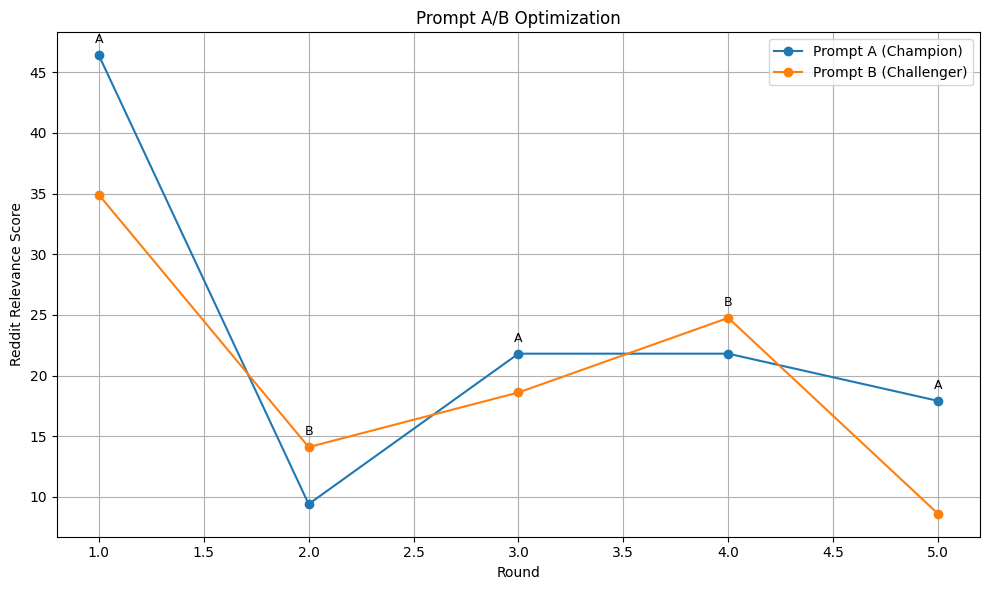

In [14]:
plot_prompt_scores(results)

In [15]:
final_prompt = results[-1]["improved_prompt"]
print(final_prompt)


Generate realistic questions a person might ask about electric vehicles and affordable family cars, suitable for a car manufacturer.  Questions should be full sentences, avoid keyword stuffing, and reflect curiosity, comparison, or buying decisions. Use the format: `label: question`.


In [16]:
questions = generate_questions(final_prompt, labeled=True)
for q in questions[:5]:
    print(q["question"])



Gemini Raw Output:
**Range & Charging:**

Real-world range: How many miles can I realistically expect to drive on a single charge in everyday driving conditions, considering things like weather and highway speeds?

Charging time:  What's the average charging time from empty to full using a Level 2 home charger, and how long would it take at a fast-charging station?

Charging infrastructure:  How easy is it to find charging stations on longer trips, and are there apps or tools to help me plan my routes?


**Cost & Ownership:**

Total cost of ownership:  Compared to a similar gas-powered car, what is the overall cost of ownership including purchase price, electricity costs, maintenance, and potential battery replacement?

Affordability: What financing options are available to make your electric vehicles more affordable for families on a budget?

Incentives: Are there any government rebates or tax credits available for purchasing an electric family car in my state?


**Family Suitability

In [17]:
def build_abstract_prompt_A(keywords: List[str], company_context: str) -> str:
    joined_keywords = ", ".join(f'"{k}"' for k in keywords)

    return f"""
You are an AI assistant trained to simulate natural human search behavior.

Keywords: {joined_keywords}
Context: {company_context}

Your task:
- Generate questions that reflect the same **intent and curiosity** as these keywords
- But do NOT use the keywords themselves or close synonyms
- Write full, natural-sounding questions like someone would ask an AI assistant

Avoid:
- Search fragments (e.g., "cheap suv family")
- Keyword-stuffed or robotic phrasing

Output:
One question per line, no bullet points, no headers.
"""


In [18]:
def build_abstract_prompt_B(keywords: List[str], company_context: str) -> str:
    return f"""
Imagine people are searching online for something related to the {company_context} industry. 

Generate questions that:
- Match the intent behind these keywords: {', '.join(keywords)}
- Do NOT use the keywords or obvious synonyms
- Still make sense to someone looking for a relevant product

Write natural human-style questions.

Output:
One question per line. No formatting or commentary.
"""


In [19]:
def optimize_prompt_loop_abstracted(
    keywords: List[str],
    company_context: str,
    reddit_client,
    rounds: int = 3
) -> List[Dict]:
    history = []

    # Initial Prompts A & B
    prompt_a = build_abstract_prompt_A(keywords, company_context)
    prompt_b = build_abstract_prompt_B(keywords, company_context)

    for i in range(rounds):
        print(f"\n\nROUND {i+1} — A/B Testing & Optimization (Abstracted Prompts)")

        # ➤ 1. Generate abstracted questions (no labels)
        questions_a = generate_questions(prompt_a, labeled=False)
        questions_b = generate_questions(prompt_b, labeled=False)

        # ➤ 2. Score both with Reddit
        print("\nScoring Prompt A...")
        score_a = evaluate_prompt_relevance(questions_a, reddit_client)

        print("\nScoring Prompt B...")
        score_b = evaluate_prompt_relevance(questions_b, reddit_client)

        # ➤ 3. Gemini judges the two
        judgment = judge_prompts_with_gemini(prompt_a, prompt_b, score_a, score_b)
        print("\nGemini Judge Output:\n" + judgment)

        # ➤ 4. Create improved prompt
        improved_prompt = improve_prompt_with_gemini(prompt_a, prompt_b, score_a, score_b)
        print(f"\nNew Improved Prompt (Round {i+1}):\n{improved_prompt}")

        # ➤ 5. Save current round to history
        history.append({
            "round": i + 1,
            "prompt_a": prompt_a,
            "score_a": score_a,
            "prompt_b": prompt_b,
            "score_b": score_b,
            "judgment": judgment,
            "improved_prompt": improved_prompt
        })

        # ➤ 6. Update prompts for next round

        # Parse Gemini judgment to determine which prompt was better
        judgment_lower = judgment.lower()
        if "prompt a is better" in judgment_lower:
            prompt_a = prompt_a
        elif "prompt b is better" in judgment_lower:
            prompt_a = prompt_b
        else:
            prompt_a = prompt_a if score_a >= score_b else prompt_b
        prompt_b = improved_prompt

    return history


In [20]:
results = optimize_prompt_loop_abstracted(
    keywords=["electric vehicle", "cheap family car"],
    company_context="Car manufacturer",
    reddit_client=reddit,
    rounds=5
)

for r in results:
    print(f"\nRound {r['round']}: A={r['score_a']} B={r['score_b']}")
    print("Best Prompt:", r['improved_prompt'][:100] + "...")




ROUND 1 — A/B Testing & Optimization (Abstracted Prompts)

Gemini Raw Output:
What affordable cars are good for families and run on electricity?

Are there any budget-friendly EVs that can comfortably seat a family?

I'm looking for an electric car that's practical for a family without breaking the bank.  What options are available?

What's the most economical electric vehicle suitable for multiple passengers?

My family needs a new car, and we're considering going electric – are there any inexpensive models?

Gemini Raw Output:
What's a good, affordable car for a growing family?
Is there an eco-friendly vehicle that won't break the bank?
Looking for a budget-friendly car with plenty of passenger space.
What are my options for a practical, economical car that's also environmentally conscious?
Need a reliable vehicle for the family that's easy on the wallet and fuel efficient?
Any suggestions for fuel-saving cars that seat at least four comfortably?
I want a family-sized car with low 

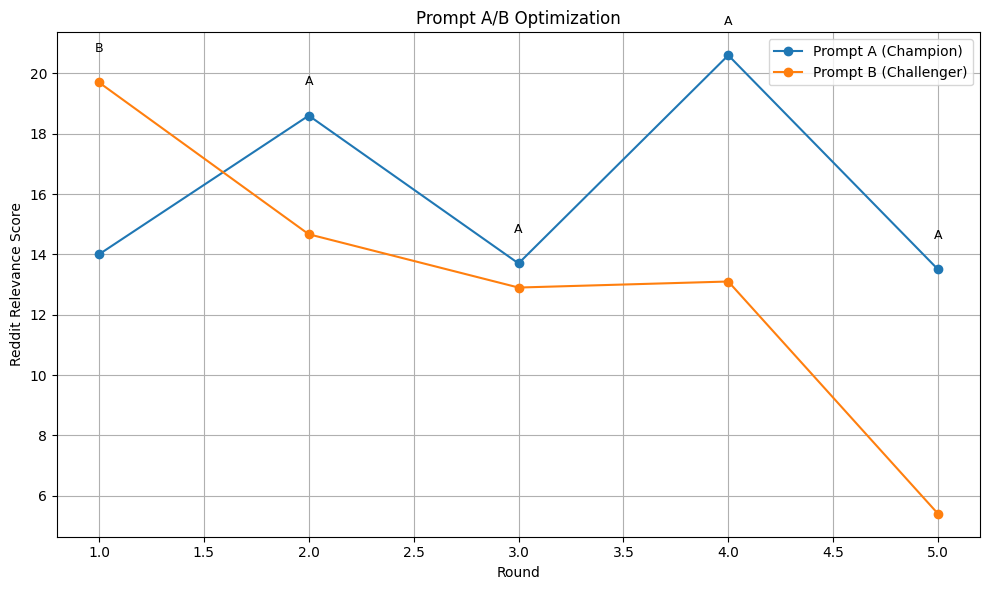

In [21]:
plot_prompt_scores(results)

In [23]:
final_prompt = results[-1]["improved_prompt"]
print(final_prompt)
questions = generate_questions(final_prompt, labeled=True)
for q in questions[:5]:
    print(q["question"])

Write realistic search questions someone might ask about affordable electric cars suitable for families, avoiding "electric vehicle," "cheap," "family car," or obvious synonyms.  One question per line.

Gemini Raw Output:
What affordable EVs seat 5 adults comfortably?
Best budget-friendly electric cars with good cargo space?
Under $30,000 electric cars with good safety ratings?
Electric vehicles for larger families: best value options?
Reliable electric cars suitable for kids and groceries?
Affordable electric car with good range for commuting and weekend trips?
What's a practical electric car for a growing family on a tight budget?
Which electric cars offer good value for money for multiple passengers?
Best used electric cars for families under $25,000?
Entry-level electric cars with spacious interiors and good features?
What affordable EVs seat 5 adults comfortably?
friendly electric cars with good cargo space?
Under $30,000 electric cars with good safety ratings?
best value options?